https://docs.solcore.solar/en/master/Examples/tutorial.html

https://github.com/qpv-research-group/solcore5/blob/develop/examples/advanced_examples/MJ_solar_cell_tutorial.py

In [1]:
from solcore import material
from solcore.structure import Layer, Structure, Junction, TunnelJunction
import solcore.poisson_drift_diffusion as PDD
import numpy as np
import solcore.quantum_mechanics as QM
from solcore.solar_cell import SolarCell
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource
import matplotlib.pyplot as plt

In [2]:
T = 298
wl = np.linspace(350, 1050, 301) * 1e-9

# First, we create the materials of the QW
QWmat = material("InGaAs")(T=T, In=0.2, strained=True)
Bmat = material("GaAsP")(T=T, P=0.1, strained=True)
i_GaAs = material("GaAs")(T=T)
# The QW is 7 nm wide, with GaAs interlayers 2 nm thick at each side and GaAsP barriers 10 nm thick.
# The final device will have 30 of these QWs.
QW = PDD.QWunit(
    [
        Layer(width=10e-9, material=Bmat, role="barrier"),
        Layer(width=2e-9, material=i_GaAs, role="well"),
        Layer(width=7e-9, material=QWmat, role="well"),
        Layer(width=2e-9, material=i_GaAs, role="well"),
        Layer(width=10e-9, material=Bmat, role="barrier"),
    ],
    T=T,
    repeat=30,
    substrate=i_GaAs,
)

# We solve the quantum properties of the QW, leaving the default values of all parameters
QW_list = QW.GetEffectiveQW(wavelengths=wl)

Solving QW properties...


In [3]:
`QW = PDD.QWunit(
    [
        Layer(width=10e-9, material=Bmat, role="barrier"),
        Layer(width=2e-9, material=i_GaAs, role="well"),
        Layer(width=7e-9, material=QWmat, role="well"),
        Layer(width=2e-9, material=i_GaAs, role="well"),
        Layer(width=10e-9, material=Bmat, role="barrier"),
    ],
    T=T,
    repeat=30,
    substrate=i_GaAs,
)

In [4]:
# T = 300

# # First, we create the materials of the QW
# QWmat = material('InGaAs')(T=T, In=0.2, strained=True)
# Bmat = material('GaAsP')(T=T, P=0.1, strained=True)
# i_GaAs = material('GaAs')(T=T)

# # The QW is 7 nm wide, with GaAs interlayers 2 nm thick at each side and GaAsP barriers 10 nm thick.
# QW = Structure([Layer(width=10e-9, material=Bmat, role="barrier"),
#                 Layer(width=2e-9, material=i_GaAs, role="interlayer"),
#                 Layer(width=7e-9, material=QWmat, role="well"),
#                 Layer(width=2e-9, material=i_GaAs, role="interlayer"),
#                 Layer(width=10e-9, material=Bmat, role="barrier") ],
#                 substrate = i_GaAs)

# # Finally, the quantum properties are calculated here
# output = QM.schrodinger(QW)

In [5]:
T = 300

## Materials for the BOTTOM junction
window_bottom = material("GaInP")(T=T, Nd=5e24, In=0.49)
n_GaAs = material("GaAs")(T=T, Nd=1e24)
p_GaAs = material("GaAs")(T=T, Na=8e22)
bsf_bottom = material("GaInP")(T=T, Na=5e24, In=0.49)

GaAs_junction = Junction(
    [
        Layer(width=10e-9, material=window_bottom, role="Window"),
        Layer(width=150e-9, material=n_GaAs, role="Emitter"),
    ]
    # Comment the following line to remove the QWs
    + QW_list
    + [
        Layer(width=2000e-9, material=p_GaAs, role="Base"),
        Layer(width=200e-9, material=bsf_bottom, role="BSF"),
    ],
    sn=1e6,
    sp=1e6,
    T=T,
    kind="PDD",
)

In [6]:
## Materials for the TOP junction
window_top = material("AlInP")(
    T=T, Nd=5e23, Al=0.53, electron_mobility=0.01, hole_mobility=7e-4
)
n_GaInP = material("GaInP")(T=T, Nd=5e23, In=0.49)
p_GaInP = material("GaInP")(T=T, Na=8e22, In=0.49)
bsf_top = material("AlInP")(
    T=T, Na=5e23, Al=0.53, electron_mobility=0.01, hole_mobility=7e-4
)
GaInP_junction = Junction(
    [
        Layer(width=120e-9, material=n_GaInP, role="Emitter"),
        Layer(width=800e-9, material=p_GaInP, role="Base"),
    ],
    sn=1e3,
    sp=1e3,
    T=T,
    kind="PDD",
)

In [7]:
tunnel = TunnelJunction(
    [Layer(width=40e-9, material=n_GaInP, role="TJ")],
    v_peak=0.2,
    j_peak=7.5e4,
    v_valley=1,
    j_valley=4e4,
    prefactor=5,
    j01=1e-23,
    kind="parametric",
    pn=True,
)

In [8]:
MgF2 = material('MgF2')()
ZnS = material('ZnScub')()

In [9]:
my_solar_cell = SolarCell(
    [
        Layer(width=110e-9, material=MgF2, role="ARC1"),
        Layer(width=60e-9, material=ZnS, role="ARC2"),
        Layer(width=30e-9, material=window_top, role="window"),
        GaInP_junction,
        Layer(width=100e-9, material=bsf_top, role="BSF"),
        tunnel,
        GaAs_junction,
    ],
    T=T,
    substrate=n_GaAs,
)

In [10]:
light_source = LightSource(
    source_type="standard",
    version="AM1.5g",
    x=wl,
    output_units="photon_flux_per_m",
    concentration=1,
)

In [11]:
solar_cell_solver(
    my_solar_cell,
    "qe",
    user_options={
        "light_source": light_source,
        "wavelength": wl,
        "optics_method": "TMM",
    },
)

Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving quantum efficiency...
Processing structure...
 CREATE MESH...
 Masternodes at (nm):
...done!

Solving equilibrium...
...done!

       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    9.50600321E-29
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
...done!

      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.1144E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.6515E-26    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.5646E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

In [12]:
num_con = 19
con = np.logspace(0, 3, num_con)
vint = np.linspace(-3.5, 4, 600)
V = np.linspace(-3.5, 0, 300)

allI = []
isc = []
voc = []
FF = []
pmpp = []

Solving IV of the junctions...
Solving IV...
Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2505E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1425E-25    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.1235E-24    0.1988E-17         2
         4   -0.1536E-15    0.2811E-16    0.1986E-16 

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2505E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1425E-25    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.1235E-24    0.1988E-17         2
         4   -0.1536E-15    0.2811E-16    0.1986E-16    0.9196E-24    0.1990E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

   288     6     2   3.60601      -147.200      0.112604E-16
   289     6     2   3.61853      -147.200      0.109760E-16
   290     6     2   3.63105      -147.200      0.107389E-16
   291     6     2   3.64357      -147.200      0.104523E-16
   292     6     2   3.65609      -147.200      0.102147E-16
   293     6     2   3.66861      -147.200      0.995865E-17
   294     6     2   3.68114      -147.200      0.968947E-17
   295     6     2   3.69366      -147.200      0.949477E-17
   296     6     2   3.70618      -147.200      0.925449E-17
   297     6     2   3.71870      -147.200      0.904292E-17
   298     6     2   3.73122      -147.200      0.880974E-17
   299     6     2   3.74374      -147.200      0.862108E-17
   300     6     2   3.75626      -147.200      0.845411E-17
   301     6     2   3.76878      -147.200      0.824163E-17
   302     6     2   3.78130      -147.200      0.802611E-17
   303     6     2   3.79382      -147.200      0.789314E-17
   304     6     2   3.8

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2912E-19    0.2505E-26    0.2917E-19         2
         2   -0.2254E-17    0.4123E-18    0.2913E-18    0.1427E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2916E-17    0.1234E-24    0.2920E-17         2
         4    0.3379E-10    0.7947E-09    0.7042E-09    0.1223E-14    0.3682E-09        

...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    7.81250000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2912E-19    0.2505E-26    0.2917E-19         2
         2   -0.2254E-17    0.4123E-18    0.2913E-18    0.1427E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2916E-17    0.1234E-24    0.2920E-17         2
         4    0.3379E-10    0.7947E-09    0.7042E-09    0.1223E-14    0.3682E-09         3
         5    0.3379E-10    0.7947E-09    0.7042E-09    0.1223E-14    0.3682E-09

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
...done!

Solving equilibrium...
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2505E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4280E-18    0.1428E-25    0.4285E-18         2
         3   -0.3309E-16    0.6060E-17    0.4284E-17    0.1234E-24    0.4287E-17         2
         4   -0.3107E-15    0.1030E-16    0.8195E-17    0.1252E-22    0.6245E-17         2
       

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
...done!
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2505E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4280E-18    0.1428E-25    0.4285E-18         2
         3   -0.3309E-16    0.6060E-17    0.4284E-17    0.1234E-24    0.4287E-17         2
         4   -0.3107E-15    0.1030E-16    0.8195E-17    0.1252E-22    0.6245E-17         2
         5   -0.3111E-14    0.1084E-17    0.9030E-18    0.3795E-23    0.5991E-18         2
         6   -0.3111E-13    0.1347E-16    0.84

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
...done!

     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8894E-19    0.6287E-19    0.2505E-26    0.6291E-19         2
         2   -0.4858E-17    0.8895E-18    0.6288E-18    0.1428E-25    0.6292E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1234E-24    0.6294E-17         2
         4   -0.4557E-15    0.2125E-16    0.2034E-16    0.2971E-22    0.6144E-17        

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.125000000     s
  
...done!

...done!

Solving IV...
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8894E-19    0.6287E-19    0.2505E-26    0.6291E-19         2
         2   -0.4858E-17    0.8895E-18    0.6288E-18    0.1428E-25    0.6292E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1234E-24    0.6294E-17         2
         4   -0.4557E-15    0.2125E-16    0.2034E-16    0.2971E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
     398.0
     407.9
     408.0
   

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
...done!
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1296E-19    0.9142E-20    0.2505E-26    0.9190E-20         2
         2   -0.7125E-18    0.1297E-18    0.9151E-19    0.1424E-25    0.9189E-19         2
         3   -0.7125E-17    0.1300E-17    0.9180E-18    0.1237E-24    0.9208E-18         2
         4   -0.7128E-16    0.1302E-16    0.9195E-17    0.9193E-24    0.9225E-17         2
       

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1296E-19    0.9142E-20    0.2505E-26    0.9190E-20         2
         2   -0.7125E-18    0.1297E-18    0.9151E-19    0.1424E-25    0.9189E-19         2
         3   -0.7125E-17    0.1300E-17    0.9180E-18    0.1237E-24    0.9208E-18         2
         4   -0.7128E-16    0.1302E-16    0.9195E-17    0.9193E-24    0.9225E-17         2
       

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
...done!

      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
...done!

Solving equilibrium...
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1907E-19    0.1346E-19    0.2505E-26    0.1351E-19         2
         2   -0.1046E-17    0.1908E-18    0.1347E-18    0.1426E-25    0.1351E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1236E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.9195E-24    0.1355E-16         

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1907E-19    0.1346E-19    0.2505E-26    0.1351E-19         2
         2   -0.1046E-17    0.1908E-18    0.1347E-18    0.1426E-25    0.1351E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1236E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.9195E-24    0.1355E-16         2
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2505E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1425E-25    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.1235E-24    0.1988E-17         2
         4   -0.1536E-15    0.2811E-16    0.1986E-16    0.9196E-24    0.1990E-16         2
       

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2505E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1425E-25    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.1235E-24    0.1988E-17         2
         4   -0.1536E-15    0.2811E-16    0.1986E-16    0.9196E-24    0.1990E-16         2
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2912E-19    0.2505E-26    0.2917E-19         2
         2   -0.2254E-17    0.4123E-18    0.2913E-18    0.1427E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2916E-17    0.1234E-24    0.2920E-17         2
         4    0.3379E-10    0.7947E-09    0.7042E-09    0.1223E-14    0.3682E-09         

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2912E-19    0.2505E-26    0.2917E-19         2
         2   -0.2254E-17    0.4123E-18    0.2913E-18    0.1427E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2916E-17    0.1234E-24    0.2920E-17         2
         4    0.3379E-10    0.7947E-09    0.7042E-09    0.1223E-14    0.3682E-09         3
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
...done!

     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    7.81250000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2505E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4280E-18    0.1428E-25    0.4285E-18         2
         3   -0.3309E-16    0.6060E-17    0.4284E-17    0.1234E-24    0.4287E-17         2
         4   -0.3107E-15    0.1030E-16    0.8195E-17    0.1252E-22    0.6245E-17         2
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
...done!

Solving equilibrium...
...done!

     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!

...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2505E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4280E-18    0.1428E-25    0.4285E-18         2
         3   -0.3309E-16    0.6060E-17    0.4284E-17    0.1234E-24    0.4287E-17         2
         4   -0.3107E-15    0.1030E-16    0.8195E-17    0.1252E-22    0.6245E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
...done!

Solving equilibrium...
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
...done!

     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.125000000     s
  
...done!
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8894E-19    0.6287E-19    0.2505E-26    0.6291E-19         2
         2   -0.4858E-17    0.8895E-18    0.6288E-18    0.1428E-25    0.6292E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1234E-24    0.6294E-17         2
         4   -0.4557E-15    0.2125E-16    0.2034E-16    0.2971E-22    0.6144E-17         

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.125000000     s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8894E-19    0.6287E-19    0.2505E-26    0.6291E-19         2
         2   -0.4858E-17    0.8895E-18    0.6288E-18    0.1428E-25    0.6292E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1234E-24    0.6294E-17         2
         4   -0.4557E-15    0.2125E-16    0.2034E-16    0.2971E-22    0.6144E-17        

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1296E-19    0.9142E-20    0.2505E-26    0.9190E-20         2
         2   -0.7125E-18    0.1297E-18    0.9151E-19    0.1424E-25    0.9189E-19         2
         3   -0.7125E-17    0.1300E-17    0.9180E-18    0.1237E-24    0.9208E-18         2
         4   -0.7128E-16    0.1302E-16    0.9195E-17    0.9193E-24    0.9225E-17         2
       

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
...done!

     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1296E-19    0.9142E-20    0.2505E-26    0.9190E-20         2
         2   -0.7125E-18    0.1297E-18    0.9151E-19    0.1424E-25    0.9189E-19         2
         3   -0.7125E-17    0.1300E-17    0.9180E-18    0.1237E-24    0.9208E-18         2
         4   -0.7128E-16    0.1302E-16    0.9195E-17    0.9193E-24    0.9225E-17         

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
...done!

Solving equilibrium...
...done!
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
...done!

Solving equilibrium...
...done!

     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
...done!

       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1907E-19    0.1346E-19    0.2505E-26    0.1351E-19         2
         2   -0.1046E-17    0.1908E-18    0.1347E-18    0.1426E-25    0.1351E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1236E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.9195E-24    0.1355E-16        

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
...done!

Solving equilibrium...
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!

...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1907E-19    0.1346E-19    0.2505E-26    0.1351E-19         2
         2   -0.1046E-17    0.1908E-18    0.1347E-18    0.1426E-25    0.1351E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1236E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.9195E-24    0.1355E-16        

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
...done!

Solving equilibrium...
...done!

     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2505E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1425E-25    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.1235E-24    0.1988E-17         2
         4   -0.1536E-15    0.2811E-16    0.1986E-16    0.9196E-24    0.1990E-16        

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2505E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1425E-25    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.1235E-24    0.1988E-17         2
         4   -0.1536E-15    0.2811E-16    0.1986E-16    0.9196E-24    0.1990E-16         2
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
...done!

       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2912E-19    0.2505E-26    0.2917E-19         2
         2   -0.2254E-17    0.4123E-18    0.2913E-18    0.1427E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2916E-17    0.1234E-24    0.2920E-17         2
         4    0.3379E-10    0.7947E-09    0.7042E-09    0.1223E-14    0.3682E-09        

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2912E-19    0.2505E-26    0.2917E-19         2
         2   -0.2254E-17    0.4123E-18    0.2913E-18    0.1427E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2916E-17    0.1234E-24    0.2920E-17         2
         4    0.3379E-10    0.7947E-09    0.7042E-09    0.1223E-14    0.3682E-09        

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
...done!

Solving equilibrium...
...done!

     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2505E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4280E-18    0.1428E-25    0.4285E-18         2
         3   -0.3309E-16    0.6060E-17    0.4284E-17    0.1234E-24    0.4287E-17         2
         4   -0.3107E-15    0.1030E-16    0.8195E-17    0.1252E-22    0.6245E-17        

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2505E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4280E-18    0.1428E-25    0.4285E-18         2
         3   -0.3309E-16    0.6060E-17    0.4284E-17    0.1234E-24    0.4287E-17         2
         4   -0.3107E-15    0.1030E-16    0.8195E-17    0.1252E-22    0.6245E-17        

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8894E-19    0.6287E-19    0.2505E-26    0.6291E-19         2
         2   -0.4858E-17    0.8895E-18    0.6288E-18    0.1428E-25    0.6292E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1234E-24    0.6294E-17         2
         4   -0.4557E-15    0.2125E-16    0.2034E-16    0.2971E-22    0.6144E-17         2
       

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8894E-19    0.6287E-19    0.2505E-26    0.6291E-19         2
         2   -0.4858E-17    0.8895E-18    0.6288E-18    0.1428E-25    0.6292E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1234E-24    0.6294E-17         2
         4   -0.4557E-15    0.2125E-16    0.2034E-16    0.2971E-22    0.6144E-17         2
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1296E-19    0.9142E-20    0.2505E-26    0.9190E-20         2
         2   -0.7125E-18    0.1297E-18    0.9151E-19    0.1424E-25    0.9189E-19         2
         3   -0.7125E-17    0.1300E-17    0.9180E-18    0.1237E-24    0.9208E-18         2
         4   -0.7128E-16    0.1302E-16    0.9195E-17    0.9193E-24    0.9225E-17         2
       

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1296E-19    0.9142E-20    0.2505E-26    0.9190E-20         2
         2   -0.7125E-18    0.1297E-18    0.9151E-19    0.1424E-25    0.9189E-19         2
         3   -0.7125E-17    0.1300E-17    0.9180E-18    0.1237E-24    0.9208E-18         2
         4   -0.7128E-16    0.1302E-16    0.9195E-17    0.9193E-24    0.9225E-17         2
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
...done!

Solving equilibrium...
...done!

      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

Solving equilibrium...
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1907E-19    0.1346E-19    0.2505E-26    0.1351E-19         2
         2   -0.1046E-17    0.1908E-18    0.1347E-18    0.1426E-25    0.1351E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1236E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.9195E-24    0.1355E-16         2
       

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
...done!

     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1907E-19    0.1346E-19    0.2505E-26    0.1351E-19         2
         2   -0.1046E-17    0.1908E-18    0.1347E-18    0.1426E-25    0.1351E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1236E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.9195E-24    0.1355E-16         2
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2505E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1425E-25    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.1235E-24    0.1988E-17         2
         4   -0.1536E-15    0.2811E-16    0.1986E-16    0.9196E-24    0.1990E-16        

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
...done!

     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    2.08982273E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2505E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1425E-25    0.1986E-18         2
         3   -0.1536E-16    0.2809E-17    0.1985E-17    0.1235E-24    0.1988E-17         2
         4   -0.1536E-15    0.2811E-16    0.1986E-16    0.9196E-24    0.1990E-16         2
       

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
...done!

     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

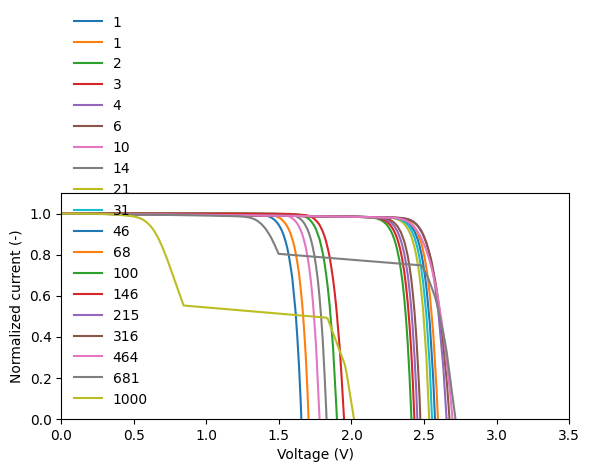

In [13]:
fig3, axIV = plt.subplots(1, 1, figsize=(6, 4))
for c in con:
    light_source.concentration = c
    solar_cell_solver(
        my_solar_cell,
        "iv",
        user_options={
            "light_source": light_source,
            "wavelength": wl,
            "optics_method": None,
            "light_iv": True,
            "mpp": True,
            "voltages": V,
            "internal_voltages": vint,
        },
    )
    isc.append(my_solar_cell.iv["Isc"])
    voc.append(my_solar_cell.iv["Voc"])
    FF.append(my_solar_cell.iv["FF"])
    pmpp.append(my_solar_cell.iv["Pmpp"])
    allI.append(my_solar_cell.iv["IV"][1])

    # And now, everything is plotting...
    axIV.plot(-V, my_solar_cell.iv["IV"][1] / isc[-1], label=int(c))

axIV.legend(loc="lower left", frameon=False)
axIV.set_ylim(0, 1.1)
axIV.set_xlim(0, 3.5)
axIV.set_xlabel("Voltage (V)")
axIV.set_ylabel("Normalized current (-)")

plt.tight_layout()
plt.show()

In [34]:
con

array([   1.        ,    1.46779927,    2.15443469,    3.16227766,
          4.64158883,    6.81292069,   10.        ,   14.67799268,
         21.5443469 ,   31.6227766 ,   46.41588834,   68.12920691,
        100.        ,  146.77992676,  215.443469  ,  316.22776602,
        464.15888336,  681.29206906, 1000.        ])

In [33]:
pmpp

[209.7034321954779,
 318.7167668934993,
 667.2710263584779,
 989.2274421232908,
 1466.143330352357,
 2172.429870264141,
 2290.015376852979,
 3465.7436263266063,
 7051.850197030332,
 10435.395528678022,
 15431.29979387323,
 22804.343426822663,
 24444.942079468554,
 36702.42324550889,
 72998.01251333143,
 106889.08483772907,
 154544.4855610448,
 182245.10887462008,
 132377.35386589868]

In [53]:
np.array(pmpp) / con / 10

array([20.97034322, 21.71392056, 30.97197745, 31.28211841, 31.58710051,
       31.88690973, 22.90015377, 23.61183646, 32.73178913, 32.99961816,
       33.24572759, 33.47219858, 24.44494208, 25.00506987, 33.88267598,
       33.80129651, 33.29560008, 26.74992373, 13.23773539])

In [38]:
abs(np.array(voc))

array([1.65454447, 1.7045395 , 2.41325259, 2.43385009, 2.45417165,
       2.47477822, 1.7798441 , 1.82818271, 2.53582537, 2.555603  ,
       2.57580412, 2.59603369, 1.8999642 , 1.94885313, 2.65580948,
       2.67562803, 2.69603895, 2.7165995 , 2.01737986])

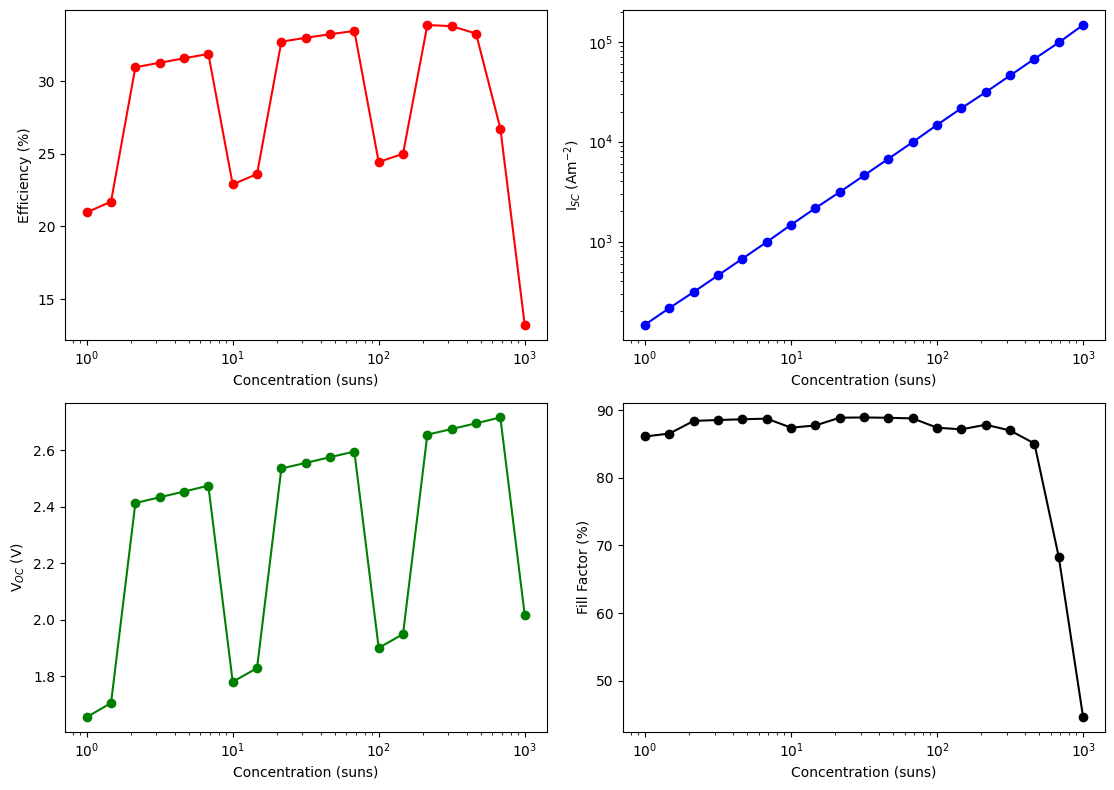

In [52]:
fig2, axes = plt.subplots(2, 2, figsize=(11.25, 8))

axes[0, 0].semilogx(con, np.array(pmpp) * con * 10, "r-o")
axes[0, 0].set_xlabel("Concentration (suns)")
axes[0, 0].set_ylabel("Efficiency (%)")

axes[0, 1].loglog(con, abs(np.array(isc)), "b-o")
axes[0, 1].set_xlabel("Concentration (suns)")
axes[0, 1].set_ylabel("I$_{SC}$ (Am$^{-2}$)")

axes[1, 0].semilogx(con, abs(np.array(voc)), "g-o")
axes[1, 0].set_xlabel("Concentration (suns)")
axes[1, 0].set_ylabel("V$_{OC}$ (V)")

axes[1, 1].semilogx(con, abs(np.array(FF)) * 100, "k-o")
axes[1, 1].set_xlabel("Concentration (suns)")
axes[1, 1].set_ylabel("Fill Factor (%)")

plt.tight_layout()
plt.show()

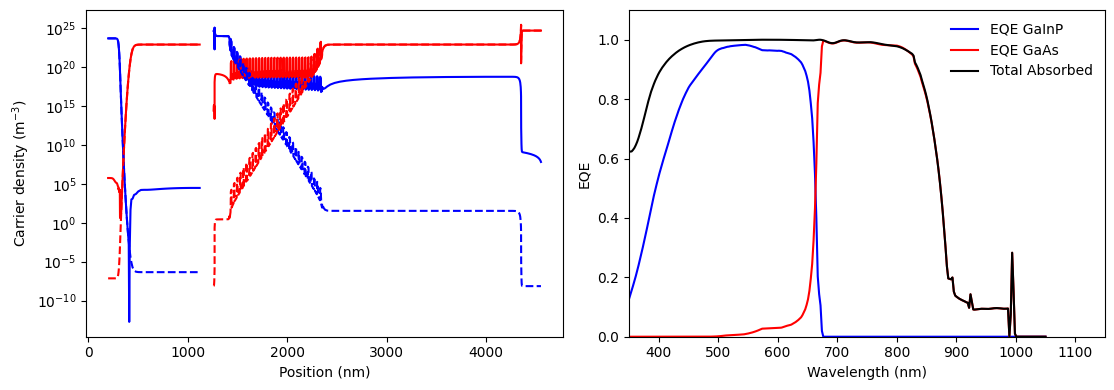

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.25, 4))
for j in my_solar_cell.junction_indices:
    zz = (
        my_solar_cell[j].short_circuit_data.Bandstructure["x"] + my_solar_cell[j].offset
    )
    n = my_solar_cell[j].short_circuit_data.Bandstructure["n"]
    p = my_solar_cell[j].short_circuit_data.Bandstructure["p"]
    ax1.semilogy(zz * 1e9, n, "b")
    ax1.semilogy(zz * 1e9, p, "r")

    zz = my_solar_cell[j].equilibrium_data.Bandstructure["x"] + my_solar_cell[j].offset
    n = my_solar_cell[j].equilibrium_data.Bandstructure["n"]
    p = my_solar_cell[j].equilibrium_data.Bandstructure["p"]
    ax1.semilogy(zz * 1e9, n, "b--")
    ax1.semilogy(zz * 1e9, p, "r--")

ax1.set_xlabel("Position (nm)")
ax1.set_ylabel("Carrier density (m$^{-3}$)")
plt.tight_layout()

# And we plot the QE
labels = ["EQE GaInP", "EQE GaAs"]
colours = ["b", "r"]
for i, j in enumerate(my_solar_cell.junction_indices):
    ax2.plot(wl * 1e9, my_solar_cell[j].eqe(wl), colours[i], label=labels[i])

ax2.plot(wl * 1e9, my_solar_cell.absorbed, "k", label="Total Absorbed")

ax2.legend(loc="upper right", frameon=False)
ax2.set_xlabel("Wavelength (nm)")
ax2.set_ylabel("EQE")
ax2.set_ylim(0, 1.1)
ax2.set_xlim(350, 1150)

plt.tight_layout()

plt.show()

In [16]:
my_solar_cell.junction_indices

[3, 6]